In [10]:
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 0. Проверка корректности тестов, видно, что $pvalue$ распределено равномерно, значит критерий корректный.

[Text(0, 0.5, 'Probability'),
 Text(0.5, 0, 'pvalue'),
 Text(0.5, 1.0, 'Equal variance ttest')]

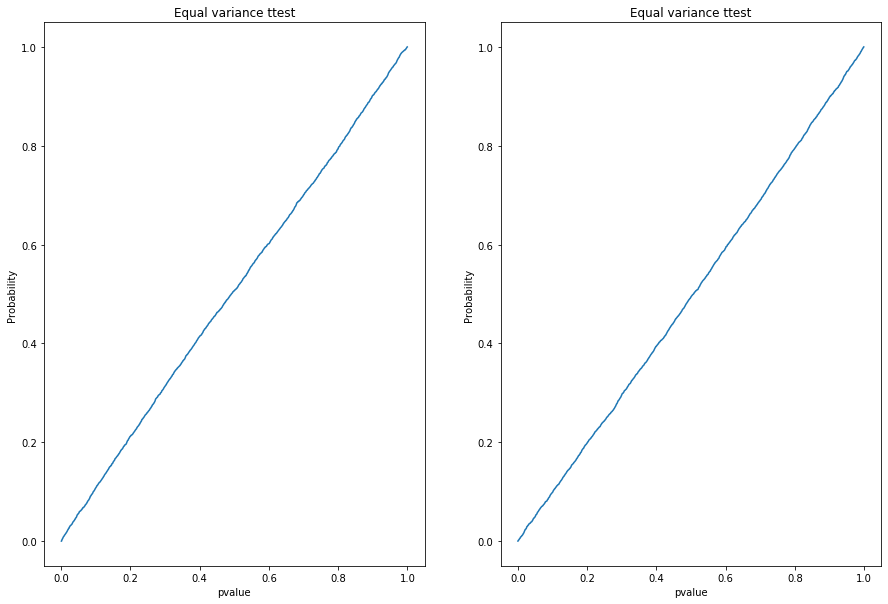

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
y_1, y_2 = [], []
for iteration in range(1, 5000):
    data_1 = np.random.normal(0, 1, 5000)
    data_2 = np.random.normal(0, 1, 5000)
    data_3 = np.random.normal(0, 3, 5000)
    y_1.append(stats.ttest_ind(data_1, data_2, equal_var=True).pvalue)
    y_2.append(stats.ttest_ind(data_1, data_3, equal_var=False).pvalue)
    
ax[0].plot(np.sort(y_1), np.linspace(0, 1, len(y_1), endpoint=False))
ax[0].set(xlabel='pvalue', ylabel='Probability', title=f'Equal variance ttest')

ax[1].plot(np.sort(y_2), np.linspace(0, 1, len(y_2), endpoint=False))
ax[1].set(xlabel='pvalue', ylabel='Probability', title=f'Equal variance ttest')

### 1. Считывание данных

In [5]:
df = pd.read_excel('../datasets/Cryotherapy.xlsx')

In [6]:
X, target = df[df.columns[:-1]], df['Result_of_Treatment']

### 1.1 Fast EDA


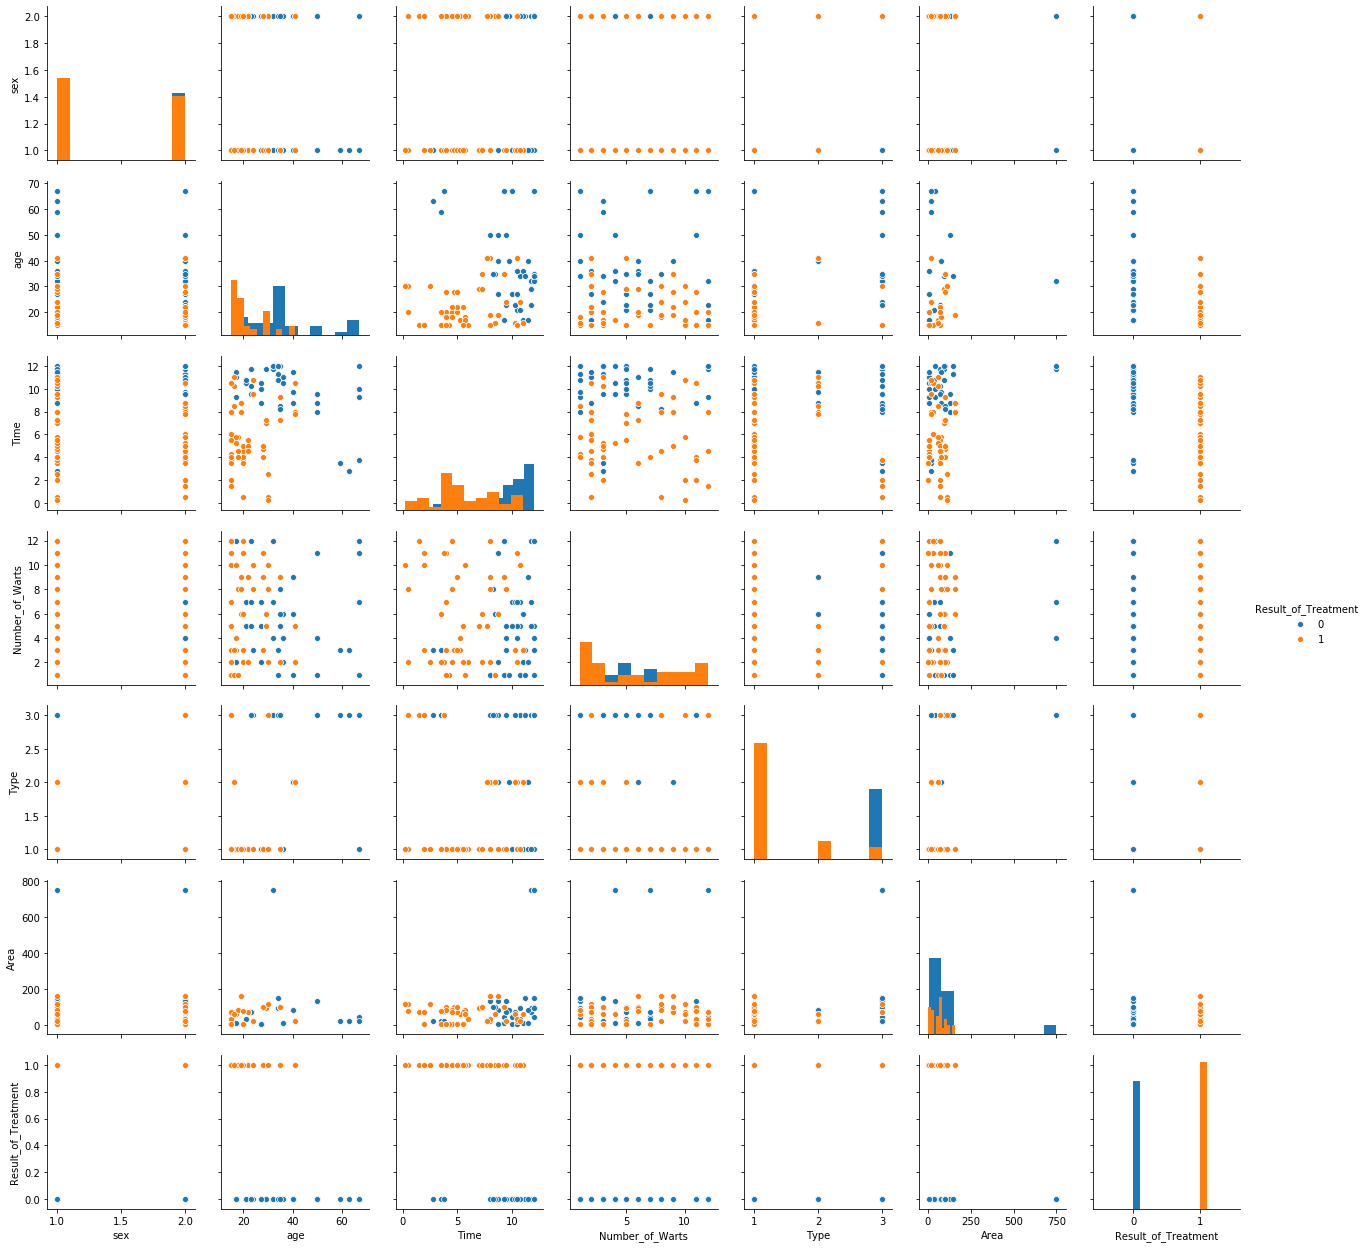

In [71]:
sns.pairplot(df, hue='Result_of_Treatment', diag_kind='hist')

### 2. Заметим, что время сильно кореллирует с результатом лечения, проверим данную гипотезу

In [7]:
df.corr()

,sex,age,Time,Number_of_Warts,Type,Area,Result_of_Treatment
sex,1.000000,-0.115185,0.074417,0.018952,0.219970,0.091213,-0.086203
age,-0.115185,1.000000,0.236305,-0.034797,0.415536,0.080915,-0.542780
Time,0.074417,0.236305,1.000000,-0.074354,0.235056,0.241559,-0.654147
Number_of_Warts,0.018952,-0.034797,-0.074354,1.000000,0.002784,0.108762,0.078273
Type,0.219970,0.415536,0.235056,0.002784,1.000000,0.354398,-0.485030
Area,0.091213,0.080915,0.241559,0.108762,0.354398,1.000000,-0.188886
Result_of_Treatment,-0.086203,-0.542780,-0.654147,0.078273,-0.485030,-0.188886,1.000000


#### 3. Заметим, что время влияет на результат лечения, попробуем проверить это как статистическую гипотезу проверив средние по времени с помощью z-test'а.
#### $H_0:$ средние равны, $H_1:$ средние не равны
#### Уровень доверия, возьмем $\alpha = 0.001$.

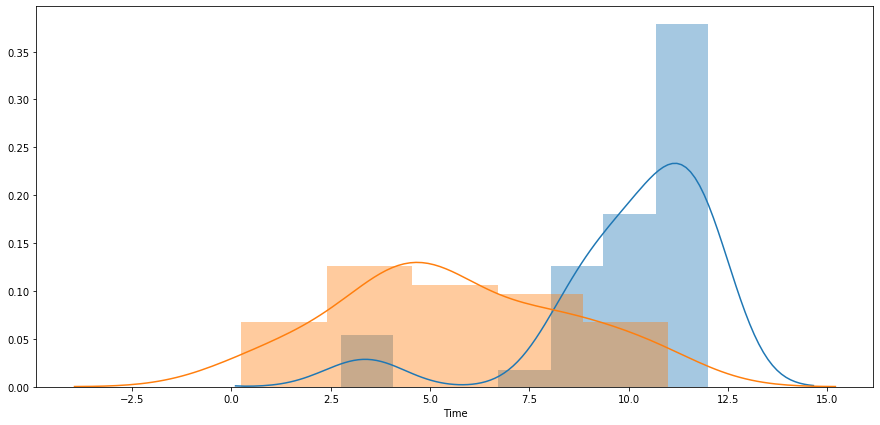

In [15]:
plt.figure(figsize=(15, 7))
sns.distplot(df[df['Result_of_Treatment'] == 0]['Time'])
sns.distplot(df[df['Result_of_Treatment'] == 1]['Time'])

#### 4. Видно, что pvalue меньше нужного уровня значимости, есть полагания отвергнуть $H_0$

In [22]:
X_1 = df[df['Result_of_Treatment'] == 0]['Time']
X_2 = df[df['Result_of_Treatment'] == 1]['Time']

stats.ttest_ind(X_1, X_2, equal_var=False)

Ttest_indResult(statistic=8.248879771426479, pvalue=1.5577538922674883e-12)

#### 5. Видно так же, что тип бородавок скореллирован с лечением, попробуем выяснить в чем проблема
#### Рассмотрим распределение борадавок по типам и посмотрим в скольких % случаев получился положительный результат

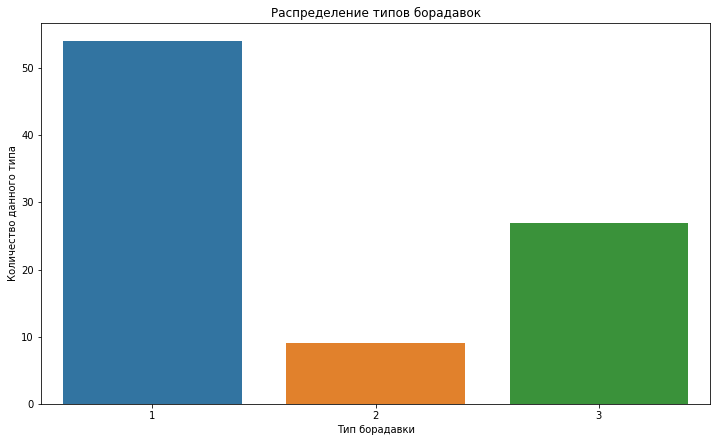

In [47]:
plt.figure(figsize=(12, 7))
g = sns.countplot(df['Type'])
g.set(title='Распределение типов борадавок', xlabel='Тип борадавки', ylabel='Количество данного типа');

#### Видно, что первого и третьего типа имеют существенные различия, второго типа имеют слишком малое количество данных для сравнения.

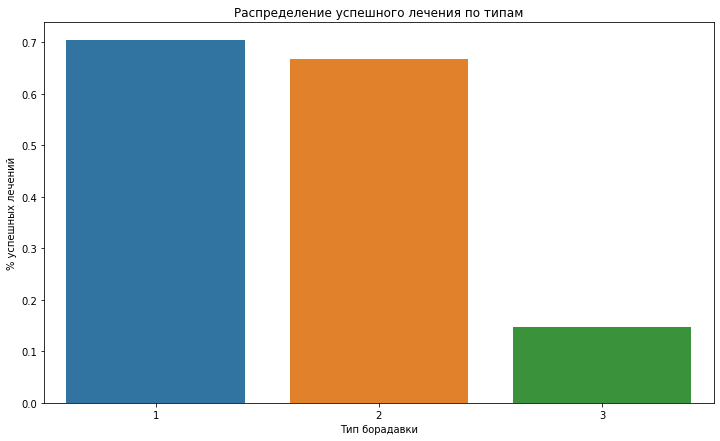

In [50]:
plt.figure(figsize=(12, 7))
g = sns.barplot(x=[1,2,3], y=df.groupby('Type').describe()['Result_of_Treatment']['mean'])
g.set(title='Распределение успешного лечения по типам', xlabel='Тип борадавки', ylabel='% успешных лечений');

#### Проверим, что борадавки третьего типа имеют распределение отличного от первого, для этого построим доверительный интервал для борадавок первого типа и третьего типа и посмотрим имеют ли они пересечение.
#### Так как в моем предположении распределение успеха лечения имеет распределение Бернулли, то будем строить доверительный интервал для него.  $H_0:$ средние равны, $H_1:$ средние не равны. Так как среднее полностью задает распределение, то будем сравнивать его и заодно получим сравнение на равенство распределений.
Будем строить доверительный интервал для каждого типа с уровнем доверия $\alpha = 0.001$.

Видно, что $pvalue$ меньше нужного уровня значимости, есть полагания отвергнуть $H_0$

In [31]:
X_1 = df[df['Type'] == 1]['Result_of_Treatment']
X_2 = df[df['Type'] == 3]['Result_of_Treatment']

stats.ttest_ind(X_1, X_2, equal_var=True)

Ttest_indResult(statistic=5.470305514707786, pvalue=5.116548243868572e-07)

### 6. Попробуем проверить, влияет ли пол на лечение
#### Для этого проверим равенсто средних (т.к. предполагается, что для успешность лечения есть с.в. с распределением Бернулли)
#### Заметим, что количество людей с разным полом в нашем датасете практически одинаково.

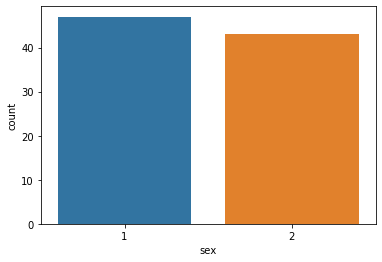

In [75]:
sns.countplot(df['sex'])

#### Попробуем проверить равенство средних, а из этого уже будет следовать равенство распределений.
#### Возьмем уровень значимости $\alpha = 0.001$
#### Видно, что $pvalue$ больше нужного уровня значимости, значит нет основания отвергнуть $H_0$ и средние предполагаются равным, а значит пол не влияет на успех лечения.

In [80]:
X_1 = df[df['sex'] == 1]['Result_of_Treatment']
X_2 = df[df['sex'] == 2]['Result_of_Treatment']
stats.ttest_ind(X_1, X_2, equal_var=True)

Ttest_indResult(statistic=0.8116742888071043, pvalue=0.41916863731488563)